In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

# Create Spark session
spark = SparkSession.builder.appName("EarthquakeDataProcessing").getOrCreate()

# Load the dataset
data = spark.read.csv('Dataset/reduced_data.csv', header=True, inferSchema=True)

# The data is already a PySpark DataFrame, so you don't need to create it again
spark_df = data

# Separate target variable 'magnitude' and features
# Excluding both 'magnitude' and 'date_time' from the features
feature_columns = [col for col in spark_df.columns if col != 'magnitude' and col != 'date_time']

# Use VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(spark_df)

# Split the data into training and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(labelCol="magnitude", featuresCol="features", seed=42)

# Define parameters for tuning
param_grid = ParamGridBuilder() \
    .addGrid(tree_regressor.maxDepth, [5, 10, 15, 20, 25, 30]).addGrid(tree_regressor.maxBins, [32, 64, 128]).build()


# Define the evaluator based on RMSE
tree_evaluator = RegressionEvaluator(metricName="rmse", labelCol="magnitude", predictionCol="prediction")

# Use TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(estimator=tree_regressor,
                           estimatorParamMaps=param_grid,
                           evaluator=tree_evaluator,  # Use tree_evaluator here
                           trainRatio=0.8)  # 80% of the data will be used for training and the remaining 20% for validation
  # 80% of the data will be used for training and the remaining 20% for validation

# Fit the model
tvs_model = tvs.fit(train_data)

# Predict with the best model
predictions_tree = tvs_model.transform(test_data)

# Calculate RMSE
rmse_tree = tree_evaluator.evaluate(predictions_tree)

# Display the best parameters and RMSE
best_model = tvs_model.bestModel
best_params_tree = {
    "maxDepth": best_model._java_obj.getMaxDepth(),
    "minInstancesPerNode": best_model._java_obj.getMinInstancesPerNode()
}

best_params_tree, rmse_tree



({'maxDepth': 5, 'minInstancesPerNode': 1}, 0.4319307707760829)

In [6]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Fit Lasso Model
lasso = LinearRegression(elasticNetParam=1, featuresCol="features", labelCol="magnitude", fitIntercept=True, standardization=True)
paramGrid_lasso = ParamGridBuilder() \
    .addGrid(lasso.regParam, [0.1, 0.01, 0.001]) \
    .build()

crossval = CrossValidator(estimator=lasso, estimatorParamMaps=paramGrid_lasso, evaluator=tree_evaluator, numFolds=5)
cvModel = crossval.fit(train_data)
bestLassoModel = cvModel.bestModel
coefficients = bestLassoModel.coefficients

selected_features_idx = [i for i, coef in enumerate(coefficients) if coef != 0]

if not selected_features_idx:  # if no features are selected
    print("No features were selected by Lasso. Using all features for the subsequent regression.")
    train_data_selected = train_data.withColumnRenamed("features", "selected_features")
    test_data_selected = test_data.withColumnRenamed("features", "selected_features")
else:
    slicer = VectorSlicer(inputCol="features", outputCol="selected_features", indices=selected_features_idx)
    train_data_selected = slicer.transform(train_data)
    test_data_selected = slicer.transform(test_data)

# Fit simple linear regression on selected features
linear_reg = LinearRegression(featuresCol="selected_features", labelCol="magnitude")
linearModel = linear_reg.fit(train_data_selected)
predictions_linear = linearModel.transform(test_data_selected)

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="magnitude", predictionCol="prediction")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="magnitude", predictionCol="prediction")

rmse_linear = evaluator_rmse.evaluate(predictions_linear)
mae_linear = evaluator_mae.evaluate(predictions_linear)

print("Linear Regression RMSE:", rmse_linear)
print("Linear Regression MAE:", mae_linear)


23/10/11 02:25:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/11 02:25:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


No features were selected by Lasso. Using all features for the subsequent regression.


23/10/11 02:25:35 WARN Instrumentation: [e978366f] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 02:25:35 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE: 0.4415746172558271
Linear Regression MAE: 0.3408512775656281


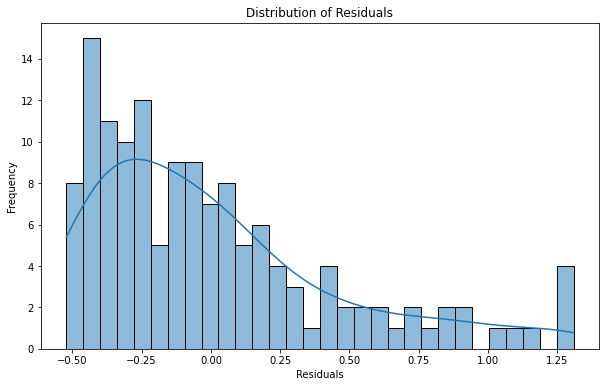

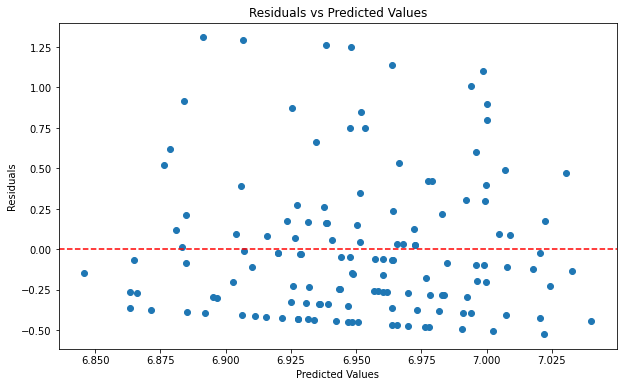

5.623292428647614e-07


In [8]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calculate the residuals
predictions_linear = predictions_linear.withColumn("residuals", col("magnitude") - col("prediction"))

# Collect residuals to the driver for plotting
residuals_list = predictions_linear.select("residuals").rdd.flatMap(lambda x: x).collect()

# Plotting is performed using Python libraries
plt.figure(figsize=(10,6))
sns.histplot(residuals_list, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# For the normality test, we collect data to the driver and use Scipy
k2, p_value_normality = stats.normaltest(residuals_list)

# For the plot of residuals vs predicted values, collect data
predicted_values = predictions_linear.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10,6))
plt.scatter(predicted_values, residuals_list)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

print(p_value_normality)


In [11]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# You've already initialized the Decision Tree Regressor in the previous code as:
# tree_regressor = DecisionTreeRegressor(labelCol="magnitude", featuresCol="features", seed=42)

# Define parameters for tuning (to match the given Scikit-learn code)
param_grid = ParamGridBuilder().addGrid(tree_regressor.maxDepth, [5, 10, 15, 20]).addGrid(tree_regressor.minInstancesPerNode, [2, 5, 10]).build()


# Use CrossValidator to find the best parameters in PySpark (equivalent to GridSearchCV)
crossval = CrossValidator(estimator=tree_regressor,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(metricName="rmse", labelCol="magnitude", predictionCol="prediction"),
                          numFolds=5)  # 5 folds as in the given code

# Fit the model
cv_model = crossval.fit(train_data)

# Predict with the best model
predictions_tree = cv_model.transform(test_data)

# Calculate RMSE
tree_evaluator = RegressionEvaluator(metricName="rmse", labelCol="magnitude", predictionCol="prediction")
rmse_tree = tree_evaluator.evaluate(predictions_tree)

# Display the best parameters and RMSE
best_model = cv_model.bestModel
best_params_tree = {
    "maxDepth": best_model._java_obj.getMaxDepth(),
    "minInstancesPerNode": best_model._java_obj.getMinInstancesPerNode()
}

best_params_tree, rmse_tree


23/10/11 02:56:16 WARN CacheManager: Asked to cache already cached data.
23/10/11 02:56:16 WARN CacheManager: Asked to cache already cached data.


({'maxDepth': 5, 'minInstancesPerNode': 5}, 0.4396046173503823)

In [14]:
from pyspark.ml.feature import VectorAssembler

# Extract the best Decision Tree model
best_tree_model = cv_model.bestModel

# Extract feature importances from the best Decision Tree model
feature_importances = best_tree_model.featureImportances

# Extracting attributes from metadata
feature_attrs = []
attrs = train_data.schema["features"].metadata["ml_attr"]["attrs"]
for attr_name in ['numeric', 'binary', 'categorical']:
    if attr_name in attrs:
        feature_attrs += attrs[attr_name]

# Extract feature names from the attributes
features = [f["name"] for f in feature_attrs]

# Combine feature names and their importances
feature_importance_dict = dict(zip(features, feature_importances.toArray()))

# Sort features based on importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")



Feature: latitude, Importance: 0.29918931743663835
Feature: longitude, Importance: 0.24621505185181897
Feature: depth, Importance: 0.1977305833163084
Feature: number_of_buildings_impacted, Importance: 0.17491339107038872
Feature: economic_loss, Importance: 0.04650772699047125
Feature: tsunami, Importance: 0.035443929334374284


In [15]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler

# Initialize the VectorAssembler for the given features
vec_assembler = VectorAssembler(inputCols=['latitude', 'longitude'], outputCol="features")

# Transform the training data
train_data_latlong = vec_assembler.transform(train_data.select(['latitude', 'longitude', 'magnitude']))  # Assuming 'magnitude' is the target column

# Initialize the Decision Tree Regressor with optimal parameters
optimized_tree_regressor = DecisionTreeRegressor(maxDepth=10, minInstancesPerNode=5, seed=42, labelCol="magnitude")

# Train the model using only 'latitude' and 'longitude' as features
model = optimized_tree_regressor.fit(train_data_latlong)

# Display the tree's rules
print(model.toDebugString)


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_645f30485330, depth=10, numNodes=143, numFeatures=2
  If (feature 0 <= 55.290549999999996)
   If (feature 0 <= 38.7595)
    If (feature 1 <= 109.426)
     If (feature 0 <= 6.66395)
      If (feature 0 <= -5.9215)
       If (feature 1 <= -176.674)
        If (feature 0 <= -21.961)
         Predict: 6.935714285714285
        Else (feature 0 > -21.961)
         Predict: 6.675000000000001
       Else (feature 1 > -176.674)
        If (feature 1 <= -73.79115)
         If (feature 0 <= -18.04885)
          If (feature 0 <= -26.6276)
           Predict: 7.160000000000001
          Else (feature 0 > -26.6276)
           Predict: 7.55
         Else (feature 0 > -18.04885)
          Predict: 6.862500000000001
        Else (feature 1 > -73.79115)
         If (feature 1 <= -24.729999999999997)
          If (feature 0 <= -20.0204)
           If (feature 0 <= -42.1699)
            Predict: 7.145454545454545
           Else (feature 0 > -42.1699)